In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import sklearn
#from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import multiprocessing
import scipy
from sklearn.model_selection import KFold

In [2]:
x_data = pd.read_excel("All features.xlsx")
x_data

,c1nc[nH]n1,c1c[nH]cn1,c1cc[nH]c1,c1ccncc1,c1ccc2[nH]ccc2c1,c1ccc2scnc2c1,c1ccc2cc3ccccc3cc2c1,c1cscn1,c1ccsc1,c1cn[nH]c1,c1ccc2occcc2c1,c1cc2ccc(ccnccc3ccc(ccn1)[nH]3)[nH]2,c1ccccc1,c1nnn[nH]1,c1ccc2sc[n+]c2c1,c1ccc2ncccc2c1,c1nncs1,Alkene,Alkylchloride,Alkylfluoride,Alkylbromide,Trifluoromethyl,Alcohol,Althoxyl,Primary_aliph_amine,Secondary_aliph_amine,Tertiary_aliph_amine,Primary_arom_amine,Secondary_arom_amine,Tertiary_arom_amine,Alkylthiol,Dialkylthioether,Disulfide,Aldehyde,Ketone,Oxime,Acetal,Hemiacetal,Thioacetal,Chloroalkene,Bromoalkene,Enol,Carboxylic_acid,Carboxylic_ester,Lactone,Amide,Lactam,Nitrile,Thiourea,Phenol,Arylchloride,Arylfluoride,Arylbromide,Aryliodide,Arylthiol,Oxoarene,Azo,Nitro,Sulfon,Sulfonic_derivative,Phosphonic_acid_derivative,Tri_boron,Sugar_pattern_combi,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,TPSA,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,Num of Conju-Strut,Num of Conju-All-Atoms,Atom Num Conju-All Ratio,AtomWt Conju-All Ratio,Full-Mol Wiener Index,Individual Conju-Atom Number (Max-Conju),Conju-Part-Wt (Max-Conju),Conju-AtomicWt (Max-Conju),Max Conju-Distance (Max-Conju),Conju-Branch Index (Max-Conju),Conju-Strut Wiener Index (Max-Conju),Atom_PEOE-Charge_Sum,Atom_LogP_Sum,Atom_MR_Sum,Atom_PEOE-Charge_Mean,Atom_LogP_Mean,Atom_MR_Mean,Atom_PEOE-Charge_Std,Atom_LogP_Std,Atom_MR_Std,Atom_PEOE-Charge_Max,Atom_LogP_Max,Atom_MR_Max,Atom_PEOE-Charge_Min,Atom_LogP_Min,Atom_MR_Min,Atom_PEOE-Charge_Delta,Atom_LogP_Delta,Atom_MR_Delta,Fun_PEOE-Charge_Sum,Fun_LogP_Sum,Fun_MR_Sum,Fun_PEOE-Charge_Mean,Fun_LogP_Mean,Fun_MR_Mean,Fun_PEOE-Charge_Std,Fun_LogP_Std,Fun_MR_Std,Fun_PEOE-Charge_Max,Fun_LogP_Max,Fun_MR_Max,Fun_PEOE-Charge_Min,Fun_LogP_Min,Fun_MR_Min,Fun_PEOE-Charge_Delta,Fun_LogP_Delta,Fun_MR_Delta,Mid-Fun_PEOE-Charge_Sum,Mid-Fun_LogP_Sum,Mid-Fun_MR_Sum,Mid-Fun_PEOE-Charge_Mean,Mid-Fun_LogP_Mean,Mid-Fun_MR_Mean,Mid-Fun_PEOE-Charge_Std,Mid-Fun_LogP_Std,Mid-Fun_MR_Std,Mid-Fun_PEOE-Charge_Max,Mid-Fun_LogP_Max,Mid-Fun_MR_Max,Mid-Fun_PEOE-Charge_Min,Mid-Fun_LogP_Min,Mid-Fun_MR_Min,Mid-Fun_PEOE-Charge_Delta,Mid-Fun_LogP_Delta,Mid-Fun_MR_Delta,Conju_PEOE-Charge_Sum,Conju_LogP_Sum,Conju_MR_Sum,Conju_PEOE-Charge_Mean,Conju_LogP_Mean,Conju_MR_Mean,Conju_PEOE-Charge_Std,Conju_LogP_Std,Conju_MR_Std,Conju_PEOE-Charge_Max,Conju_LogP_Max,Conju_MR_Max,Conju_PEOE-Charge_Min,Conju_LogP_Min,Conju_MR_Min,Conju_PEOE-Charge_Delta,Conju_LogP_Delta,Conju_MR_Delta,Atom Number,Occupied Orbitals,Molecule Weight,HOMO,LUMO,HOMO-LUMO Gap,Farthest Distance,Molecular Radius,Molecular Size Short,Molecular Size Medium,Molecular Size Long,Long/Sum Size Ratio,Length/Diameter,MPP,SDP,Dipole Moment (a.u.),Quadrupole Moment,Octopole Moment,ODI LUMO+1,ODI LUMO,ODI HOMO,ODI HOMO-1,ODI Mean,ODI Std,Isosurface area,Sphericity,Volume (Angstrom^3),Density (g/cm^3),LEAE Minimal Value,LEAE Maximal Value,Surfac

In [3]:
y_data = pd.read_csv("Target.csv", usecols=[4])
y_data

,FE formate
0,7.257787
1,2.081697
2,12.348173
3,3.004140
4,5.017220
...,...
77,2.400569
78,3.491043
79,2.594404
80,4.349028


In [4]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_data.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in x_data.columns.values]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=0)

In [5]:
scaler1 = preprocessing.MinMaxScaler().fit(x_train)  
scaler2 = preprocessing.MinMaxScaler().fit(y_train)

x_train = scaler1.transform(x_train)
x_test = scaler1.transform(x_test)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)

In [6]:
num_cores = multiprocessing.cpu_count()

In [7]:
kf = KFold(n_splits=10, random_state=0, shuffle=True) 

variate=list(range(x_train.shape[1]))  
selected=[]   
train_mse_list = []
val_mse_list = []

current_score,best_new_score=float('inf'),float('inf')  

    
# def my_custom_loss_func(y, y_predict):
#     error = 0
#     for i in range(0, y.shape[1]):
#         error += mean_squared_error(y[:, i], y_predict[:, i])
#     error = error / y.shape[1]
#     return error

# my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)


while variate:
    mse_with_variate_train = []
    mse_with_variate_val=[]
    for i in variate:  
        current_variate = selected+[i]   
        current_x_train = x_train[:, current_variate]   
        current_x_test = x_test[:, current_variate]   
        
        train_mse_list_ = []
        val_mse_list_ = []
        
        for train_index, val_index in kf.split(current_x_train, y_train):
            x_train_ = current_x_train[train_index, :]
            x_val_ = current_x_train[val_index, :]
            y_train_ = y_train[train_index, :]
            y_val_ = y_train[val_index, :]
            
            #model = MLPRegressor(random_state=0,early_stopping=True,alpha=0.0001,hidden_layer_sizes=(1,),learning_rate_init=0.01,
            #                    max_iter=5000,n_iter_no_change=100)
            svr = SVR(kernel='rbf')
            multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
            multioutput_svr.fit(x_train_, y_train_)
        
            train_pre = multioutput_svr.predict(x_train_)
            val_pre = multioutput_svr.predict(x_val_)
            
            train_mse_ = mean_squared_error(y_train_, train_pre)
    
            val_mse_ = mean_squared_error(y_val_, val_pre)
    
            train_mse_list_.append(train_mse_)
    
            val_mse_list_.append(val_mse_)
            
        train_mse = np.mean(train_mse_list_)
        
        val_mse = np.mean(val_mse_list_)
        
        mse_with_variate_train.append((train_mse,i))
        
        mse_with_variate_val.append((val_mse,i))
            
    min_mse_index = mse_with_variate_val.index(min(mse_with_variate_val))
    best_new_score,best_candidate_index = mse_with_variate_val[min_mse_index]
    train_new_score,_ = mse_with_variate_train[min_mse_index]
        
    variate.remove(best_candidate_index)  
    selected.append(best_candidate_index)  
    
    train_mse_list.append(mse_with_variate_train[min_mse_index][0])
    
    val_mse_list.append(mse_with_variate_val[min_mse_index][0])
        
       

In [8]:
selected

[299,
 3,
 305,
 300,
 227,
 158,
 244,
 237,
 220,
 100,
 175,
 8,
 234,
 38,
 302,
 75,
 226,
 243,
 45,
 107,
 127,
 146,
 196,
 61,
 304,
 238,
 31,
 89,
 108,
 97,
 247,
 212,
 210,
 65,
 63,
 193,
 64,
 268,
 116,
 57,
 113,
 303,
 174,
 19,
 229,
 25,
 21,
 180,
 5,
 10,
 215,
 183,
 262,
 44,
 55,
 0,
 1,
 2,
 4,
 6,
 9,
 99,
 11,
 13,
 15,
 16,
 18,
 20,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 95,
 41,
 43,
 47,
 17,
 53,
 56,
 60,
 62,
 110,
 240,
 249,
 46,
 14,
 256,
 109,
 135,
 111,
 257,
 270,
 301,
 157,
 160,
 201,
 130,
 71,
 206,
 242,
 251,
 241,
 250,
 293,
 49,
 139,
 119,
 98,
 59,
 27,
 121,
 246,
 58,
 177,
 73,
 118,
 22,
 23,
 161,
 245,
 295,
 141,
 198,
 137,
 124,
 195,
 129,
 258,
 216,
 213,
 159,
 138,
 248,
 204,
 219,
 123,
 51,
 207,
 225,
 96,
 269,
 211,
 194,
 275,
 239,
 259,
 285,
 74,
 134,
 122,
 148,
 152,
 217,
 179,
 271,
 92,
 189,
 205,
 42,
 101,
 128,
 231,
 221,
 120,
 230,
 267,
 214,
 228,
 222,
 32,
 114,
 29,
 162,
 91,
 232,
 255,
 19

In [9]:
train_mse_list

[0.029596382786293396,
 0.022531853632922247,
 0.019984264449007957,
 0.01936525016236549,
 0.014750545815516044,
 0.008462212498787838,
 0.008051525933142996,
 0.008123244398273064,
 0.008019302477207422,
 0.008040502986586977,
 0.007861367381572022,
 0.007827430152308364,
 0.007900015900239211,
 0.007930211012525815,
 0.007796355151581742,
 0.007412550115652795,
 0.007537502921747642,
 0.007605209040210022,
 0.007719974531604515,
 0.007344036280448806,
 0.007384159204913492,
 0.007297875610648716,
 0.00683959264531246,
 0.006856070842411166,
 0.006848998233877494,
 0.006978721888442956,
 0.007137410492403015,
 0.007280242270284787,
 0.00723941971448457,
 0.007246446129967871,
 0.00718138083573696,
 0.007136946053414575,
 0.007169775508585716,
 0.007095163693593663,
 0.007036165869326594,
 0.007018521919317053,
 0.007019729010695289,
 0.007115146968272874,
 0.007149670167504216,
 0.0071606445915782385,
 0.007199109531119223,
 0.007005197569467743,
 0.006953188529726021,
 0.00695499461

In [10]:
val_mse_list

[0.035181566134219,
 0.026550470677251182,
 0.024850383916505944,
 0.024234170762619724,
 0.022597483477602428,
 0.021078765747669957,
 0.019754870578880146,
 0.018463144019535315,
 0.01796885592746551,
 0.017622442348146406,
 0.017237487177678597,
 0.01650833757088844,
 0.01637562390254232,
 0.01634969705276095,
 0.0163850837426938,
 0.016277094978436064,
 0.01618663558257878,
 0.016129516095194567,
 0.016136808018868975,
 0.016167755578437203,
 0.0158770593572145,
 0.01566672698030218,
 0.01537191354147629,
 0.01536085602242147,
 0.01539023135501738,
 0.015392417399474709,
 0.015356099582923425,
 0.015134255639994997,
 0.01500252901847681,
 0.014974690951396055,
 0.014981751309434613,
 0.014873937858908576,
 0.014760564052004013,
 0.01449857177082417,
 0.014250668545433534,
 0.014171152892200167,
 0.01419850681040678,
 0.014214829296610595,
 0.014226400433533362,
 0.014230130889258952,
 0.014248917940567114,
 0.014204764773146838,
 0.014222477045076305,
 0.014244493272620794,
 0.0142

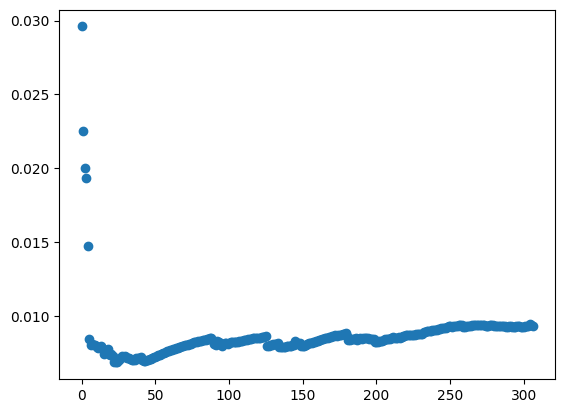

In [11]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.scatter(range(len(train_mse_list)), train_mse_list)
plt.show()

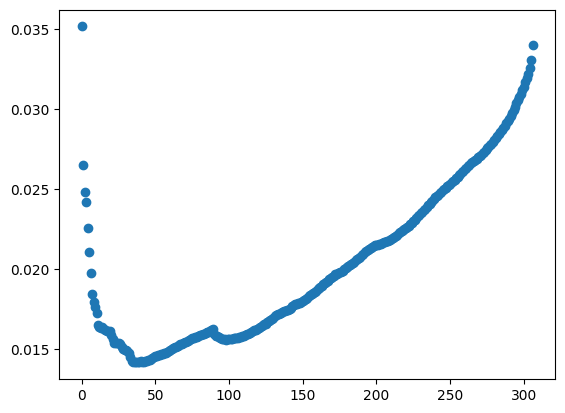

In [12]:
plt.scatter(range(len(val_mse_list)), val_mse_list)
plt.show()

In [7]:
min_index  = val_mse_list.index(min(val_mse_list))
min_value = val_mse_list[min_index]
print(min_index)
print(min_value)

35
0.014171152892200167


In [10]:
selected_columns = x_data.columns[selected[:min_index+1]].tolist()
for col in selected_columns:
    print(col)

Atom1_ESP All area (Ang^2)
c1ccncc1
Atom1_ALIE Max value
Atom1_ESP Minimal value (kcal/mol)
Mid-Fun_MR_Max
NumAromaticRings
Conju_LogP_Max
Conju_PEOE-Charge_Mean
Mid-Fun_LogP_Mean
PEOE_VSA2
Conju-Part-Wt (Max-Conju)
c1ccsc1
Conju_PEOE-Charge_Sum
Thioacetal
Atom1_ESP All average (kcal/mol)
BalabanJ
Mid-Fun_LogP_Max
Conju_PEOE-Charge_Max
Amide
PEOE_VSA9
SlogP_VSA8
VSA_EState7
Atom_LogP_Delta
Tri_boron
Atom1_ALIE Min value
Conju_LogP_Mean
Dialkylthioether
HallKierAlpha
SMR_VSA1
PEOE_VSA12
Conju_LogP_Min
Fun_MR_Min
Fun_PEOE-Charge_Min
MinAbsEStateIndex
MaxAbsEStateIndex
Atom_LogP_Min


In [20]:
#col_index = [sorted_index[i] for i in selected[:min_index+1]]
import os

save_dir = 'Selected features'
os.makedirs(save_dir, exist_ok=True) 
data = x_data[selected_columns]
output_file = os.path.join(save_dir, "selected_features-formate.csv")
data.to_csv(output_file, index=False, encoding='utf_8_sig')
data

,Atom1_ESP All area (Ang^2),c1ccncc1,Atom1_ALIE Max value,Atom1_ESP Minimal value (kcal/mol),Mid-Fun_MR_Max,NumAromaticRings,Conju_LogP_Max,Conju_PEOE-Charge_Mean,Mid-Fun_LogP_Mean,PEOE_VSA2,Conju-Part-Wt (Max-Conju),c1ccsc1,Conju_PEOE-Charge_Sum,Thioacetal,Atom1_ESP All average (kcal/mol),BalabanJ,Mid-Fun_LogP_Max,Conju_PEOE-Charge_Max,Amide,PEOE_VSA9,SlogP_VSA8,VSA_EState7,Atom_LogP_Delta,Tri_boron,Atom1_ALIE Min value,Conju_LogP_Mean,Dialkylthioether,HallKierAlpha,SMR_VSA1,PEOE_VSA12,Conju_LogP_Min,Fun_MR_Min,Fun_PEOE-Charge_Min,MinAbsEStateIndex,MaxAbsEStateIndex,Atom_LogP_Min
0,16.87092,0,15.596793,16.841987,34.0375,1,0.6122,-1.259678e-01,0.413467,4.794537,108.121,1,-1.259678e-01,0,39.01412,2.903362,0.6122,-1.259678e-01,0,4.877147,0.0,0.000000,1.1680,1,9.858382,0.6122,0,-0.645065,14.842582,0.0,0.6122,5.2285,-0.124460,0.053796,10.728455,-0.5443
1,17.21584,0,15.107320,0.743094,32.0190,1,2.5106,-4.160000e-17,2.510600,0.000000,160.015,1,-4.160000e-17,0,20.66318,3.049648,2.5106,-4.160000e-17,0,3.786415,0.0,0.000000,0.7226,0,9.734129,2.5106,0,0.180000,0.000000,0.0,2.5106,8.9270,-0.038952,1.196759,3.299769,0.1230
2,13.47059,0,14.326353,-7.521853,8.9860,0,-0.4222,-1.231819e-01,-0.020850,4.794537,44.009,0,-1.231819e-01,0,24.20452,2.847379,0.3805,-1.231819e-01,0,5.752854,0.0,0.000000,0.9375,0,8.768344,-0.4222,0,-0.180000,9.901065,0.0,-0.4222,7.6358,-0.123182,0.083333,9.291667,-0.2893
3,16.36156,0,14.612181,-13.944614,15.1820,0,-0.4222,-1.337200e-01,0.150667,9.589074,44.009,0,-2.674400e-01,0,21.85000,3.007306,1.2964,-1.337200e-01,0,12.841643,0.0,0.259401,0.9375,0,8.509234,-0.4222,0,-0.360000,19.802129,0.0,-0.4222,7.6358,-0.187114,0.129700,10.023517,-0.2893
4,16.81620,0,13.237998,-37.500848,10.1970,0,0.6792,-1.928926e-02,0.679200,0.000000,24.022,0,-3.857851e-02,0,-10.74523,2.679549,0.6792,-1.928926e-02,0,0.000000,0.0,3.793981,0.8517,0,7.853093,0.6792,0,-0.170000,0.000000,0.0,0.6792,10.1970,-0.019289,1.033750,3.577361,-0.2035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,15.75442,0,14.221609,-33.995517,8.9860,0,0.0000,0.000000e+00,0.380500,0.000000,0.000,0,0.000000e+00,0,-8.02671,2.727243,0.3805,0.000000e+00,0,0.000000,0.0,10.967467,0.9159,0,8.026730,0.0000,0,0.700000,0.000000,0.0,0.0000,8.9860,-0.077161,1.055211,4.183278,-0.2677
78,15.77360,0,14.306894,-33.510114,8.9860,0,0.0000,0.000000e+00,0.380500,0.000000,0.000,0,0.000000e+00,0,-7.49396,2.647605,0.3805,0.000000e+00,0,0.000000,0.0,8.044435,0.9159,0,8.027367,0.0000,0,0.700000,0.000000,0.0,0.0000,8.9860,-0.077161,1.048182,4.151822,-0.2677
79,15.79733,0,14.519096,-32.282694,8.9860,0,0.0000,0.000000e+00,0.380500,0.000000,0.000,0,0.000000e+00,0,-5.85622,2.447473,0.3805,0.000000e+00,0,0.000000,0.0,3.764228,0.9159,0,8.035676,0.0000,0,0.700000,0.000000,0.0,0.0000,8.9860,-0.077161,1.021605,4.068503,-0.2677
80,15.79664,0,14.338035,-30.906308,8.9860,0,0.0000,0.000000e+00,0.380500,0.000000,0.000,0,0.000000e+00,0,-4.26869,2.339092,0.3805,0.000000e+00,0,0.000000,0.0,2.402006,0.9159,0,8.049127,0.0000,0,0.700000,0.000000,0.0,0.0000,8.9860,-0.077160,1.000556,4.020664,-0.2677


In [12]:
from sklearn.metrics import mean_squared_error, r2_score

min_val_mse_index=min_index
final_x_train = x_train[:, selected[:min_val_mse_index+1]]
final_x_test = x_test[:, selected[:min_val_mse_index+1]]

svr = SVR(kernel='rbf')
multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
multioutput_svr.fit(final_x_train, y_train)

test_pred = multioutput_svr.predict(final_x_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

test_mse = round(test_mse, 4)
test_r2 = round(test_r2, 4)

print(f"Selected variables based on validation MSE: {selected_columns}")
print(f"Test MSE: {test_mse}")
print(f"Test R2: {test_r2}")

import os
save_dir = 'Test mse after svr'
os.makedirs(save_dir, exist_ok=True)  
output_file1 = os.path.join(save_dir, "final_evaluation-formate.csv")

df_summary = pd.DataFrame({
    'Selected Variables': [selected_columns],
    'Final Test MSE': [test_mse],
    'Final Test R2': [test_r2]
})
df_summary.to_csv(output_file1, index=False)

print(f"Results saved to '{output_file1}'")

Selected variables based on validation MSE: ['Atom1_ESP All area (Ang^2)', 'c1ccncc1', 'Atom1_ALIE Max value', 'Atom1_ESP Minimal value (kcal/mol)', 'Mid-Fun_MR_Max', 'NumAromaticRings', 'Conju_LogP_Max', 'Conju_PEOE-Charge_Mean', 'Mid-Fun_LogP_Mean', 'PEOE_VSA2', 'Conju-Part-Wt (Max-Conju)', 'c1ccsc1', 'Conju_PEOE-Charge_Sum', 'Thioacetal', 'Atom1_ESP All average (kcal/mol)', 'BalabanJ', 'Mid-Fun_LogP_Max', 'Conju_PEOE-Charge_Max', 'Amide', 'PEOE_VSA9', 'SlogP_VSA8', 'VSA_EState7', 'Atom_LogP_Delta', 'Tri_boron', 'Atom1_ALIE Min value', 'Conju_LogP_Mean', 'Dialkylthioether', 'HallKierAlpha', 'SMR_VSA1', 'PEOE_VSA12', 'Conju_LogP_Min', 'Fun_MR_Min', 'Fun_PEOE-Charge_Min', 'MinAbsEStateIndex', 'MaxAbsEStateIndex', 'Atom_LogP_Min']
Test MSE: 0.0452
Test R2: 0.3792
Results saved to 'Test mse after svr/final_evaluation-formate.csv'
